## Exercício - Ciencia de Dados

### Instruções e dataset para o candidato:
---
#### dataset:
* df_train.csv
* df_test_no_label.csv
____
#### problema:

O objetivo do exercicio é predizer para que país o usuário do serviço fará sua primeira viagem. 
Esse label está contido na coluna ‘country_destination’.
Trata-se de um problema de classifiação multi-classe. Os possíveis valores são:
	- NDF
	- US
	- FR
	- IT

correspondentes a quatro possibilidades do usuário.

As outras colunas contém features do usuário, que podem ser tanto categoricas quanto numéricas.

A avaliação será feita com duas metricas:
* logloss: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html
* ROC_AUC: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html (*)

No dia da entrevista, trazer o seu algoritmo para validação em uma massa out-of-sample.
A submissão deverá ser um csv, contendo as probabilidades de cada label com a seguinte convenção: ```{'NDF': 0, 'US': 1, 'FR': 2, 'IT': 3}```

Exemplo:<br>
```
0.7,0.1,0.1,0.1
0.3,0.3,0.3,0.1
0.25,0.25,0.25,0.25
```
A primeira linha traz NDF com probabilidade de 70%, e US/FR/IT com 10% cada.<br>
A segunda linha traz NDF/US/FR com probabilidade 30% cada e IT com 10%.<br>
A terceira linha traz cada um dos quatro labels com 25% de probabilidade.

(\*) No caso do ROC_AUC consideraremos como ```'NDF'``` como label negativo, e ```'US', 'FR', 'IT'``` como label positivo.

Caso haja alguma dúvida favor entrar em contato.

----

# Imports

In [1]:
from datetime import datetime
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import seaborn as sns
import holidays
import calendar
from sklearn import preprocessing
from multiprocessing import  Pool
import os
from sklearn import preprocessing
from scipy import stats
from sklearn import metrics
import numpy as np
import pickle
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

#Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/home/luiz/anaconda3/envs/sula/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Data

In [2]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test_no_label.csv')

In [3]:
df_analise = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Analise

In [4]:
df_analise.shape

(194777, 16)

In [5]:
df_analise.head(2)

,Unnamed: 0,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,192293,wqpe22hwjb,2014-05-20,20140520182222,-unknown-,NaN,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,IE,NDF
1,141719,l144s4m9mu,2014-01-14,20140114180853,FEMALE,28.0,basic,0,en,other,other,omg,Web,Mac Desktop,Safari,FR


In [6]:
df_analise.sort_values(by='Unnamed: 0').head(10)

,Unnamed: 0,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
173945,0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN
101986,1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
96601,2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
33156,4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
147410,5,osr2jwljor,2010-01-01,20100101215619,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,NaN
124387,6,lsw9q7uk0j,2010-01-02,20100102012558,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
103916,7,0d01nltbrs,2010-01-03,20100103191905,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
4312,8,a1vcnhxeij,2010-01-04,20100104004211,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
70955,9,6uh8zyj2gn,2010-01-04,20100104023758,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US
136874,10,yuuqmid2rp,2010-01-04,20100104194251,FEMALE,36.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Firefox,US


Observando a coluna **Unnamed: 0** podemos inferir que possivelmente essa coluna representa um index, então já iremos dropar

In [7]:
df_analise.drop(columns='Unnamed: 0', inplace=True)
df_train.drop(columns='Unnamed: 0', inplace=True)
df_test.drop(columns='Unnamed: 0', inplace=True)

Substituindo **unknown** por nan

In [8]:
df_analise.replace('-unknown-', np.nan, inplace=True)
df_train.replace('-unknown-', np.nan, inplace=True)
df_test.replace('-unknown-', np.nan, inplace=True)

Observando valores vazios nas colunas dos datasets

In [9]:
pd.concat([(df_analise.isna().sum() / df_analise.shape[0]) .round(4) * 100,
           (df_train.isna().sum() / df_train.shape[0]) .round(4) * 100,
          (df_test.isna().sum() / df_test.shape[0]) .round(4) * 100], axis=1).rename(columns={0: 'df_analise',
                                                                                             1:'df_train',
                                                                                             2:'df_test'})

,df_analise,df_train,df_test
id,0.00,0.00,0.00
date_account_created,0.00,0.00,0.00
timestamp_first_active,0.00,0.00,0.00
gender,45.97,45.90,46.16
age,42.87,42.86,42.89
signup_method,0.00,0.00,0.00
signup_flow,0.00,0.00,0.00
language,0.00,0.00,0.00
affiliate_channel,0.00,0.00,0.00
affiliate_provider,0.00,0.00,0.00


Podemos observar que a coluna com um volume representativo de valores vazios são as colunas idade e genero, a coluna idade possui porcentagem de vazios proporcionais nos 3 dataset. Apesar do volume de vazios acreditamos que esta variavel pode ser importante no decorre da modelagem, então, não iremos remove-la

**Transformando datetime**

In [10]:
df_analise['date_account_created'] = df_analise['date_account_created'].apply(pd.to_datetime)
df_train['date_account_created'] = df_train['date_account_created'].apply(pd.to_datetime)
df_test['date_account_created'] = df_test['date_account_created'].apply(pd.to_datetime)

Observando variações

In [11]:
df_analise.describe()

,timestamp_first_active,age,signup_flow
count,1.947770e+05,111281.000000,194777.000000
mean,2.013091e+13,49.755951,3.369499
std,9.228965e+09,156.204193,7.754188
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


Observando as variações podemos observar algumas informações estranhas na coluna **idade**, então para todas as idades acima de 110 anos iremos substituir por vazios 

In [12]:
df_analise.loc[df_analise[df_analise['age'] > 110].index, 'age'] = np.nan
df_train.loc[df_analise[df_analise['age'] > 110].index, 'age'] = np.nan
df_test.loc[df_analise[df_analise['age'] > 110].index, 'age'] = np.nan

Observando novamente a variação de idade

In [13]:
df_analise.describe()

,timestamp_first_active,age,signup_flow
count,1.947770e+05,110564.000000,194777.000000
mean,2.013091e+13,37.398484,3.369499
std,9.228965e+09,13.887104,7.754188
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,110.000000,25.000000


In [14]:
def get_date_info(DATA):
    
    DATA['timestamp_first_active'] = pd.to_datetime(DATA['timestamp_first_active'], format='%Y%m%d%H%M%S')
    DATA['timestamp_first_active'] = DATA['timestamp_first_active'].apply(lambda x: x.date())
    
    DATA['year'] = DATA['date_account_created'].apply(lambda x: x.year )
    DATA['month'] = DATA['date_account_created'].apply(lambda x: x.month )
    DATA['day'] = DATA['date_account_created'].apply(lambda x: x.day )
    DATA['day_name'] = DATA['date_account_created'].apply(lambda x: x.day_name() )
    
    DATA['year_first_act'] = DATA['date_account_created'].apply(lambda x: x.year )
    DATA['month_first_act'] = DATA['date_account_created'].apply(lambda x: x.month )
    DATA['day_first_act'] = DATA['date_account_created'].apply(lambda x: x.day )
    DATA['day_name_first_act'] = DATA['date_account_created'].apply(lambda x: x.day_name() )
    
    return DATA

def parallelize_dataframe(df, func, n_cores=10):
    """
        For optimize feature engeeniring i used multitheding function
        Recive dataframe and the funcion to apply process
    """
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def dummies_test(test_data):
    test_data = test_data[['gender', 'signup_method', 'signup_flow', 'language','affiliate_channel', 
                           'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 
                           'first_device_type', 'first_browser', 'day_name','day_name_first_act']]
    
    #categorical_data = test_data.select_dtypes(
    #    include=['category', object]).columns
    test_data = pd.get_dummies(test_data, dtype=bool)
    
    for c in colunas_dummies:
        if c not in test_data.columns:
            test_data[c] = False

    return test_data[colunas_dummies]

In [15]:
df_analise = parallelize_dataframe(df_analise, get_date_info)
df_train = parallelize_dataframe(df_train, get_date_info)
df_test = parallelize_dataframe(df_test, get_date_info)

In [16]:
df_analise[~df_analise['gender'].isnull()]

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,first_browser,country_destination,year,month,day,day_name,year_first_act,month_first_act,day_first_act,day_name_first_act
1,l144s4m9mu,2014-01-14,2014-01-14,FEMALE,28.0,basic,0,en,other,other,...,Safari,FR,2014,1,14,Tuesday,2014,1,14,Tuesday
3,1u2r6m6ets,2013-07-01,2013-07-01,MALE,30.0,basic,0,en,direct,direct,...,Chrome,US,2013,7,1,Monday,2013,7,1,Monday
6,8jyawwei6k,2012-08-21,2012-08-21,FEMALE,33.0,basic,0,en,direct,direct,...,Firefox,US,2012,8,21,Tuesday,2012,8,21,Tuesday
7,nioqwo8o2v,2014-01-08,2014-01-08,FEMALE,34.0,basic,0,en,direct,direct,...,Safari,US,2014,1,8,Wednesday,2014,1,8,Wednesday
8,1qe3fct1ax,2014-06-26,2014-06-26,FEMALE,46.0,facebook,0,en,seo,facebook,...,Mobile Safari,US,2014,6,26,Thursday,2014,6,26,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194770,rru0qtr038,2014-02-26,2014-02-26,FEMALE,48.0,basic,25,en,direct,direct,...,NaN,NaN,2014,2,26,Wednesday,2014,2,26,Wednesday
194771,6moapv315m,2011-08-17,2011-08-17,FEMALE,39.0,basic,0,en,sem-brand,google,...,Mobile Safari,NaN,2011,8,17,Wednesday,2011,8,17,Wednesday
194772,q1du71hvdx,2011-07-21,2011-07-21,FEMALE,48.0,basic,3,en,sem-non-brand,google,...,IE,NaN,2011,7,21,Thursday,2011,7,21,Thursday
194773,ocqot42ir4,2011-10-13,2011-10-13,MALE,43.0,facebook,0,en,direct,direct,...,Chrome,NaN,2011,10,13,Thursday,2011,10,13,Thursday


**Observando distribuição de idade e distribuições das idades por sexo**

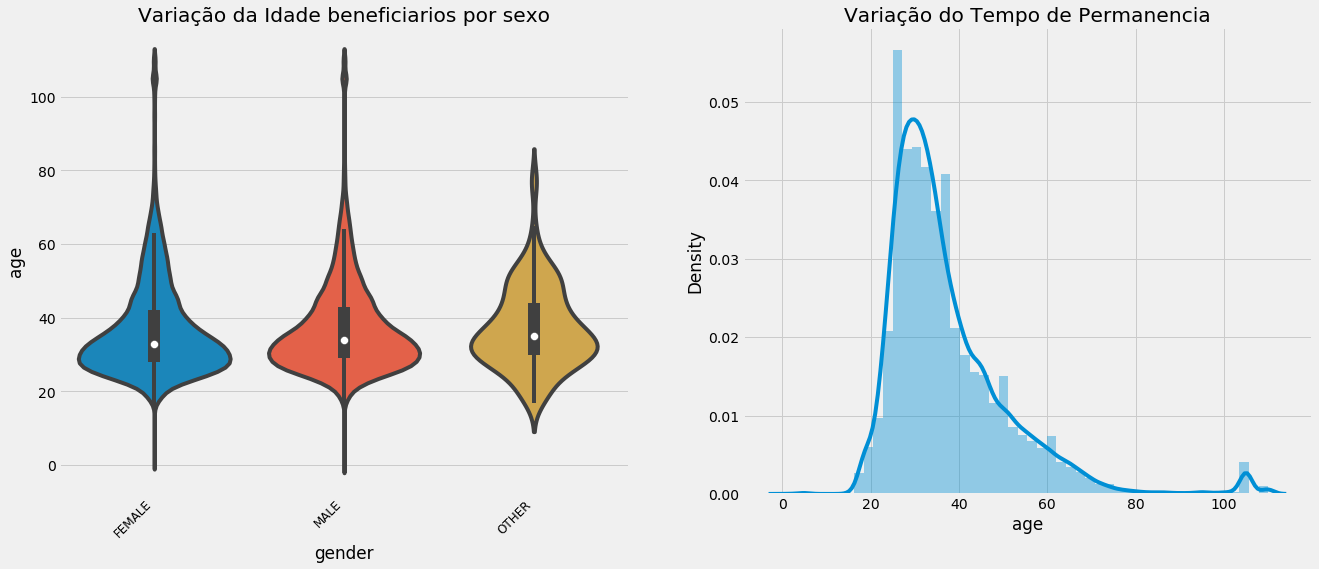

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(20, 8))

sns.violinplot(x ='gender', y='age', data=df_analise[~df_analise['gender'].isnull()], ax=ax[0])
ax[0].set_xticklabels(df_analise[~df_analise['gender'].isnull()]['gender'].unique(), rotation=45, horizontalalignment='right', fontsize=12)
ax[0].set_title('Variação da Idade beneficiarios por sexo')

sns.distplot(df_analise['age'], ax=ax[1])
ax[1].set_title('Variação do Tempo de Permanencia')


plt.show()

- Podemos observar uma similaridade nas distribuições quando olhamos o sexo
- Olhando a distribuição da idade como um todo podemos observar quase uma distribuição normal onde os maiores volumes estão dentro da faixa de 26 à 38  

**Analise de quantidade de procuras no site por ano e por genero**

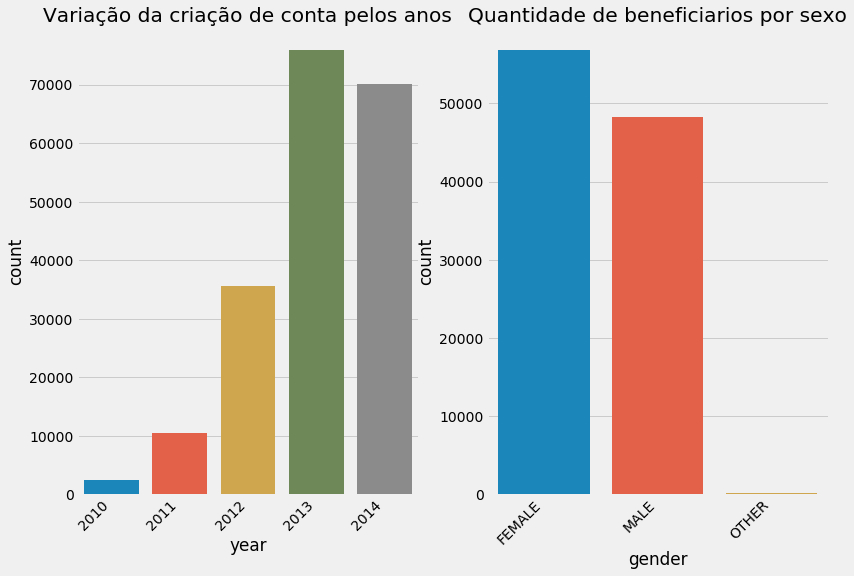

In [18]:
fig, ax = plt.subplots(1, 2,figsize=(12, 8))

sns.countplot(x = 'year', data=df_analise, ax=ax[0])
ax[0].set_xticklabels(np.sort(df_analise['year'].unique()), rotation=45, horizontalalignment='right')
ax[0].set_title('Variação da criação de conta pelos anos')

sns.countplot(x = 'gender', data=df_analise[~df_analise['gender'].isnull()], ax=ax[1])
ax[1].set_xticklabels(df_analise[~df_analise['gender'].isnull()]['gender'].unique(), rotation=45, horizontalalignment='right')
ax[1].set_title('Quantidade de beneficiarios por sexo')

plt.show()

In [19]:
df_analise['day_name'].unique()

array(['Tuesday', 'Thursday', 'Monday', 'Wednesday', 'Sunday', 'Friday',
       'Saturday'], dtype=object)

**Observando quantidade de acessos de beneficiarios por mes e dia da semana**

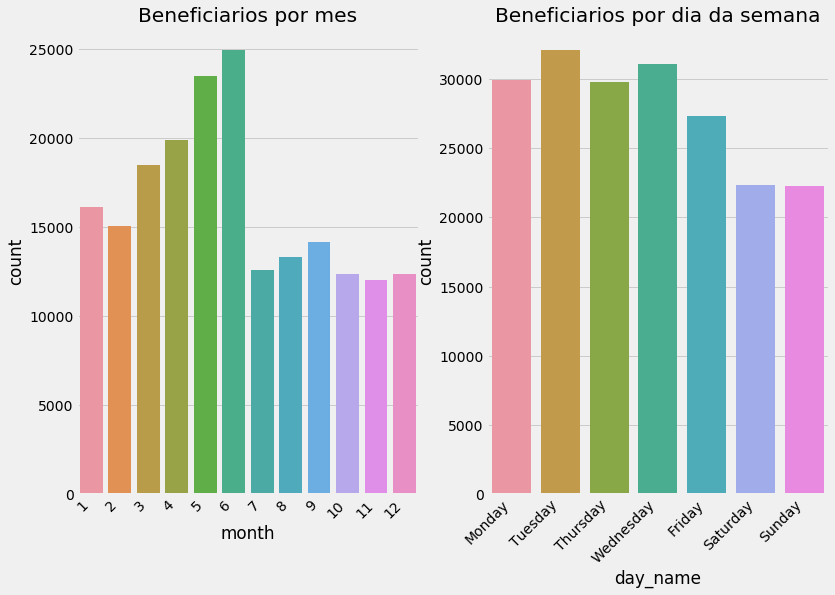

In [20]:
fig, ax = plt.subplots(1, 2,figsize=(12, 8))
order = ['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday',
       'Saturday', 'Sunday']

sns.countplot(x = 'month', data=df_analise, ax=ax[0], order=np.sort(df_analise['month'].unique()))
ax[0].set_xticklabels(np.sort(df_analise['month'].unique()), rotation=45, horizontalalignment='right')
ax[0].set_title('Beneficiarios por mes')

sns.countplot(x = 'day_name', data=df_analise, ax=ax[1], order=order)
ax[1].set_xticklabels(order, rotation=45, horizontalalignment='right')
ax[1].set_title('Beneficiarios por dia da semana')

plt.show()

- Podemos observar uma maior quantidade de buscas nos meses 5, 6 e 1 o que pode ser devido as ferias escolares 
- Analisando os dias da semana podemos observar um maior volume na terça e quarta

**Analise de destinos escolhidos pelos beneficiarios(usuarios)**

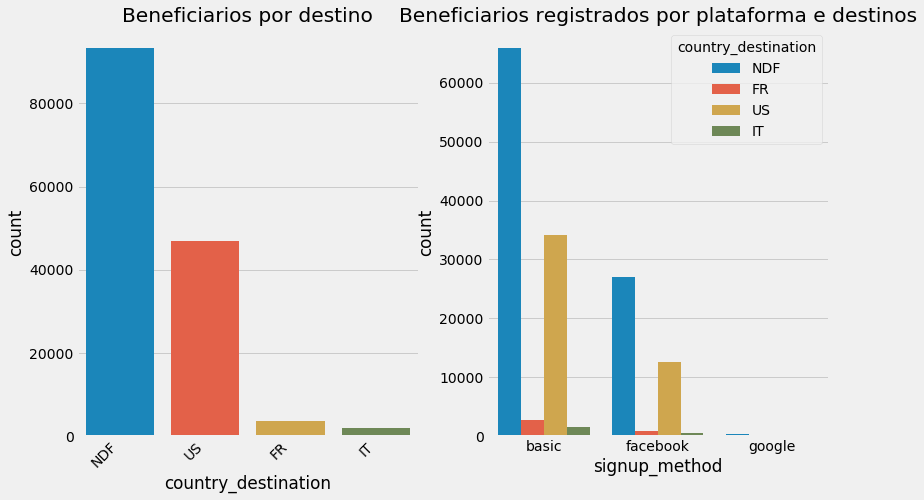

In [21]:
fig, ax = plt.subplots(1, 2,figsize=(12, 7))
order = ['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday',
       'Saturday', 'Sunday']

sns.countplot(x = 'country_destination', data=df_analise, ax=ax[0], order=['NDF','US', 'FR', 'IT'])
ax[0].set_xticklabels(['NDF','US', 'FR', 'IT'], rotation=45, horizontalalignment='right')
ax[0].set_title('Beneficiarios por destino')

sns.countplot(x='signup_method', data = df_analise, hue = 'country_destination', ax=ax[1])
plt.title('Beneficiarios registrados por plataforma e destinos')

plt.show()

- Observando os dados podemos observar que a maioria dos usuarios não realizam a escolha de destino ou não utilizam a plataforma
- Analisando os usuarios por tipo de **signup_method** podemos observar que a maioria utiliza o email pessoal tanto olhando pessoas que não fecharam as viagens como as que fecharam 

# Analisando diferenças de comportamentos quando os desfechos

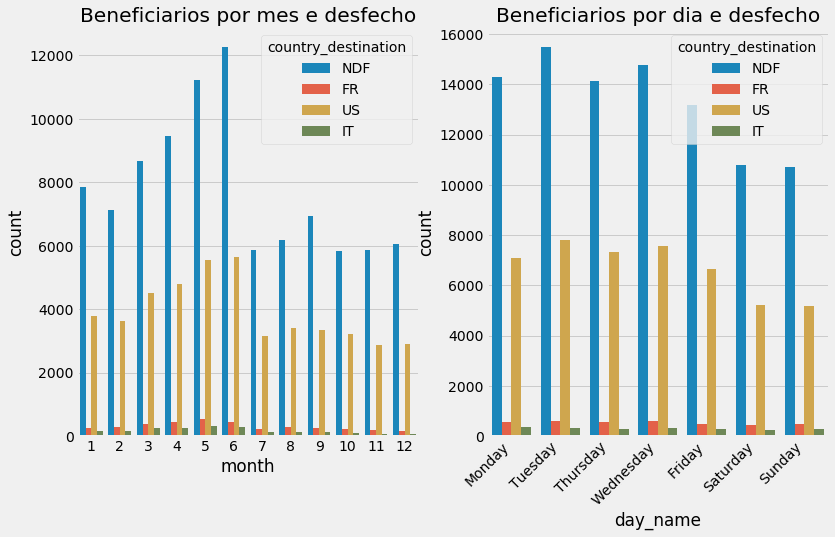

In [22]:
fig, ax = plt.subplots(1, 2,figsize=(12, 7))
order = ['Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday',
       'Saturday', 'Sunday']

sns.countplot(x = 'month', data=df_analise, ax=ax[0], order=np.sort(df_analise['month'].unique()),  hue = 'country_destination')
ax[0].set_title('Beneficiarios por mes e desfecho')

sns.countplot(x='day_name', data = df_analise, hue = 'country_destination', ax=ax[1], order=order)
ax[1].set_xticklabels(order, rotation=45, horizontalalignment='right')
ax[1].set_title('Beneficiarios por dia e desfecho')

plt.show()

- Olhando os volumes dos beneficiarios por desfecho podemos constatar que tanto o dia da semana quanto o mes de criação da conta não possuem grande influencias no desfecho/escolha do beneficiario 

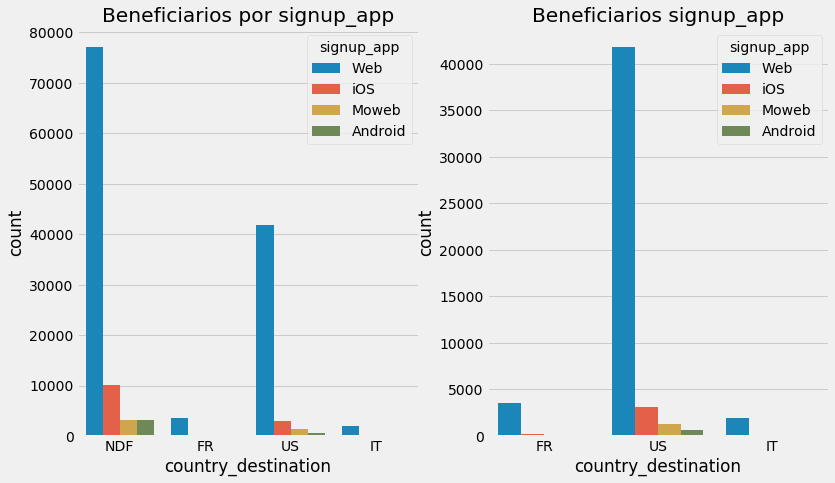

In [23]:
fig, ax = plt.subplots(1, 2,figsize=(12, 7))

sns.countplot(x = 'country_destination', data=df_analise, ax=ax[0],  hue = 'signup_app')
ax[0].set_title('Beneficiarios por signup_app')

sns.countplot(x = 'country_destination', data=df_analise[~df_analise.isin(['NDF'])], hue = 'signup_app', ax=ax[1])
ax[1].set_title('Beneficiarios signup_app')

plt.show()

- Observando os volumes dos beneficiarios por desfecho (fechamento ou não da viagem) podemos constatar que comportamento se mantem para os dois desfechos, mas é necessario frisar o alto volume de viagens para **US**

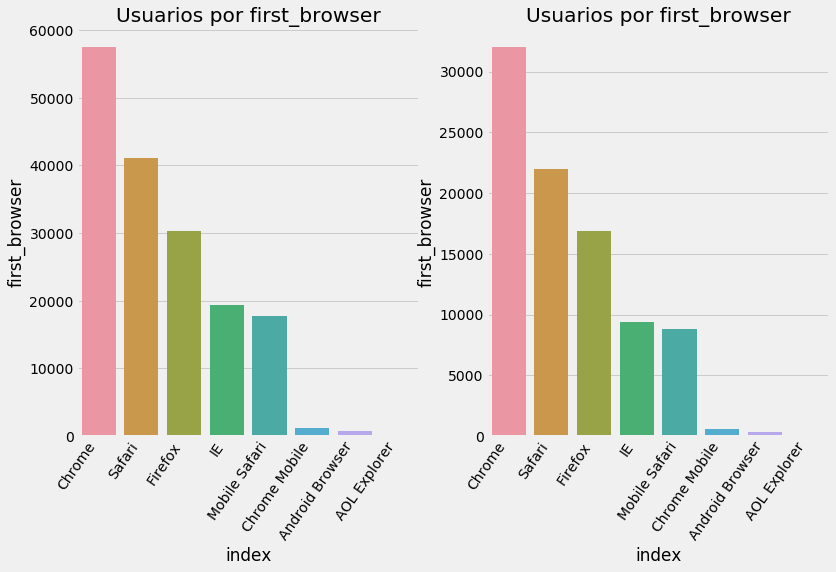

In [24]:
compare = df_analise['first_browser'].value_counts()[:8].to_frame().reset_index()
compare_2 = df_analise[df_analise['country_destination'] !='NDF']['first_browser'].value_counts()[:8].to_frame().reset_index()

fig, ax = plt.subplots(1, 2,figsize=(12, 7))

sns.barplot(x='index', y='first_browser' ,data=compare, ax=ax[0])
ax[0].set_xticklabels(compare['index'], rotation=55, horizontalalignment='right')
ax[0].set_title('Usuarios por first_browser')

sns.barplot(x='index', y='first_browser' ,data=compare_2, ax=ax[1])
ax[1].set_xticklabels(compare_2['index'], rotation=55, horizontalalignment='right')
ax[1].set_title('Usuarios por first_browser')

plt.show()

- Observando os volumes dos beneficiarios podemos constatar que comportamento se mantem para os dois desfechos (fechamento ou não da viagem), mas podemos observar a maior volumetria de utilização dos navegadores **Chrome, Safari e Firefox**

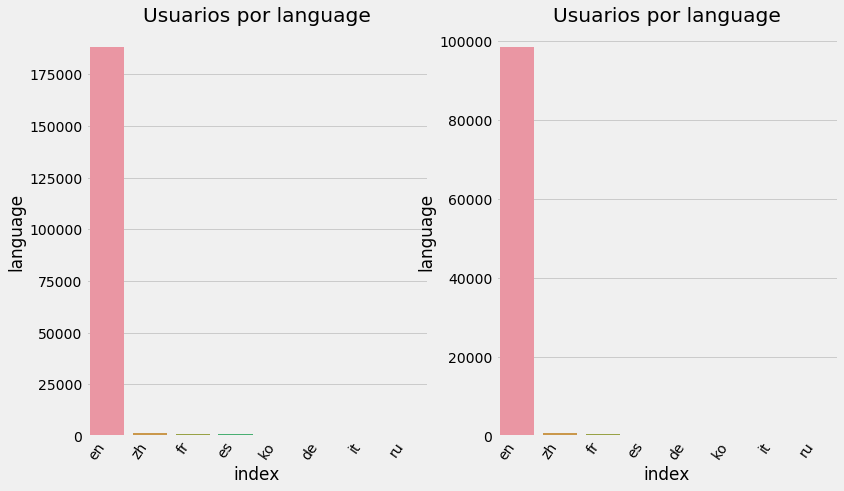

In [25]:
compare = df_analise['language'].value_counts()[:8].to_frame().reset_index()
compare_2 = df_analise[df_analise['country_destination'] !='NDF']['language'].value_counts()[:8].to_frame().reset_index()

fig, ax = plt.subplots(1, 2,figsize=(12, 7))

sns.barplot(x='index', y='language' ,data=compare, ax=ax[0])
ax[0].set_xticklabels(compare['index'], rotation=55, horizontalalignment='right')
ax[0].set_title('Usuarios por language')

sns.barplot(x='index', y='language' ,data=compare_2, ax=ax[1])
ax[1].set_xticklabels(compare_2['index'], rotation=55, horizontalalignment='right')
ax[1].set_title('Usuarios por language')

plt.show()

- Observando os volumes dos beneficiarios por desfecho podemos constatar que comportamento se mantem para os dois desfechos (fechamento ou não da viagem), mas podemos observar a grande volumetria de utilização da lingua inglesa


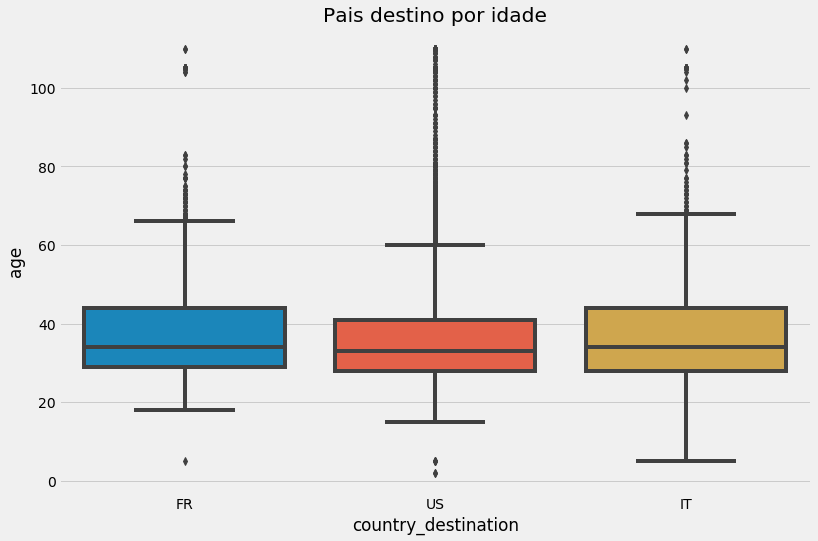

In [26]:
plt.figure(figsize=(12,8))

sns.boxplot(y='age', x='country_destination',data= df_analise[df_analise['country_destination'] !='NDF'])
plt.title('Pais destino por idade')
plt.show()

- Podemos observer que a media de idades dos usuarios com destino para **FR** é um pouco maior que o resto dos paises. Alem disso podemos observar o alto volume de outliers dos usuarios que tem como destino os **US**

# Feature Engineering

In [27]:
df_train_dummy = pd.get_dummies(df_train[['gender', 'signup_method', 'signup_flow', 'language','affiliate_channel', 
                           'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 
                           'first_device_type', 'first_browser', 'day_name','day_name_first_act']])

colunas_dummies = df_train_dummy.columns

In [28]:
df_train = pd.concat([df_train, df_train_dummy], axis=1)

In [29]:
df_train.head(2)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_name_first_act_Friday,day_name_first_act_Monday,day_name_first_act_Saturday,day_name_first_act_Sunday,day_name_first_act_Thursday,day_name_first_act_Tuesday,day_name_first_act_Wednesday
0,wqpe22hwjb,2014-05-20,2014-05-20,NaN,NaN,basic,0,en,sem-non-brand,google,...,0,1,0,0,0,0,0,0,1,0
1,l144s4m9mu,2014-01-14,2014-01-14,FEMALE,28.0,basic,0,en,other,other,...,0,1,0,0,0,0,0,0,1,0


In [30]:
df_train['country_destination'].unique()

array(['NDF', 'FR', 'US', 'IT'], dtype=object)

In [31]:
df_train['country_destination'].value_counts()

NDF    93383
US     46848
FR      3728
IT      2123
Name: country_destination, dtype: int64

Substituaindo labels

In [32]:
di = {'NDF': 0, 'US': 1, 'FR': 2, 'IT': 3}

df_train["country_destination"].replace(di, inplace=True)

Transformando dataframe para dummys 

In [33]:
df_test_dummy = parallelize_dataframe(df_test, dummies_test)

df_test = pd.concat([df_test, df_test_dummy], axis=1)

In [34]:
df_test.head(2)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_name_first_act_Friday,day_name_first_act_Monday,day_name_first_act_Saturday,day_name_first_act_Sunday,day_name_first_act_Thursday,day_name_first_act_Tuesday,day_name_first_act_Wednesday
0,oib8mib64c,2014-04-10,2014-04-10,NaN,NaN,basic,25,en,direct,direct,...,True,False,False,False,False,False,False,True,False,False
1,6ooe791roo,2013-10-29,2013-10-29,NaN,NaN,basic,23,en,direct,direct,...,False,True,False,False,False,False,False,False,True,False


Observando shape dos dataframes

In [35]:
df_train.shape

(146082, 160)

In [36]:
df_test.shape

(48695, 159)

In [37]:
df_train.head(2)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_name_first_act_Friday,day_name_first_act_Monday,day_name_first_act_Saturday,day_name_first_act_Sunday,day_name_first_act_Thursday,day_name_first_act_Tuesday,day_name_first_act_Wednesday
0,wqpe22hwjb,2014-05-20,2014-05-20,NaN,NaN,basic,0,en,sem-non-brand,google,...,0,1,0,0,0,0,0,0,1,0
1,l144s4m9mu,2014-01-14,2014-01-14,FEMALE,28.0,basic,0,en,other,other,...,0,1,0,0,0,0,0,0,1,0


In [38]:
df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)

In [39]:
df_train.head(2)

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_name_first_act_Friday,day_name_first_act_Monday,day_name_first_act_Saturday,day_name_first_act_Sunday,day_name_first_act_Thursday,day_name_first_act_Tuesday,day_name_first_act_Wednesday
id,,,,,,,,,,,,,,,,,,,,,
wqpe22hwjb,2014-05-20,2014-05-20,NaN,NaN,basic,0,en,sem-non-brand,google,omg,...,0,1,0,0,0,0,0,0,1,0
l144s4m9mu,2014-01-14,2014-01-14,FEMALE,28.0,basic,0,en,other,other,omg,...,0,1,0,0,0,0,0,0,1,0


Removendo colunas que foram "dummizadas"

In [40]:
df_train.drop(columns=['date_account_created','timestamp_first_active','gender', 'signup_method', 'signup_flow', 'language','affiliate_channel', 
                           'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 
                           'first_device_type', 'first_browser', 'day_name','day_name_first_act'], inplace=True)

df_test.drop(columns=['date_account_created','timestamp_first_active','gender', 'signup_method', 'signup_flow', 'language','affiliate_channel', 
                           'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 
                           'first_device_type', 'first_browser', 'day_name','day_name_first_act'], inplace=True)

In [48]:
df_train.loc[: , df_train.columns != "country_destination"].head(2)

,age,year,month,day,year_first_act,month_first_act,day_first_act,gender_FEMALE,gender_MALE,gender_OTHER,...,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_name_first_act_Friday,day_name_first_act_Monday,day_name_first_act_Saturday,day_name_first_act_Sunday,day_name_first_act_Thursday,day_name_first_act_Tuesday,day_name_first_act_Wednesday
id,,,,,,,,,,,,,,,,,,,,,
wqpe22hwjb,NaN,2014,5,20,2014,5,20,0,0,0,...,0,1,0,0,0,0,0,0,1,0
l144s4m9mu,28.0,2014,1,14,2014,1,14,1,0,0,...,0,1,0,0,0,0,0,0,1,0


Verificando formato dos dataframes

In [42]:
df_train.shape

(146082, 144)

In [43]:
df_test.shape

(48695, 143)

Realizando K-fold para definição do modelo a ser utilizado

In [44]:
models = [LGBMClassifier(objective='multi:mlogloss', n_jobs=-1), XGBClassifier(objective='multi:mlogloss', n_jobs=-1)]

kfold = KFold(n_splits=10)

for model in models:

    print("\n", type(model).__name__)
    
    results = cross_val_score(model, df_train.loc[: , df_train.columns != "country_destination"], df_train['country_destination'], cv=kfold, scoring='neg_log_loss')

    print(f"\n{type(model).__name__} Model Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


 LGBMClassifier

LGBMClassifier Model Accuracy: -70.38% (0.60%)

 XGBClassifier
[20:01:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:01:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:02:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:02:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from '

O modelo LGBMClassifier foi escolhido depois de analisado a performance

# Classifier

In [45]:
lgb = LGBMClassifier(objective='multi:mlogloss', n_jobs=-1)                  
lgb.fit(df_train.loc[: , df_train.columns != "country_destination"], df_train['country_destination'])

LGBMClassifier(objective='multi:mlogloss')

In [46]:
df_test.head(2)

,age,year,month,day,year_first_act,month_first_act,day_first_act,gender_FEMALE,gender_MALE,gender_OTHER,...,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_name_first_act_Friday,day_name_first_act_Monday,day_name_first_act_Saturday,day_name_first_act_Sunday,day_name_first_act_Thursday,day_name_first_act_Tuesday,day_name_first_act_Wednesday
id,,,,,,,,,,,,,,,,,,,,,
oib8mib64c,NaN,2014,4,10,2014,4,10,False,False,False,...,True,False,False,False,False,False,False,True,False,False
6ooe791roo,NaN,2013,10,29,2013,10,29,False,False,False,...,False,True,False,False,False,False,False,False,True,False


# Submissão

In [47]:
#Prediction
y_pred = lgb.predict_proba(df_test.loc[: , df_test.columns != "country_destination"])
pred_prob = pd.DataFrame(y_pred, index=df_test.index)
pred_prob['Predictions'] = pred_prob.values.tolist()
pred_prob[['Predictions']].to_csv('submissao_list.csv')
pred_prob.iloc[:,:-1].to_csv('submissao_split.csv')

# Conclusão

O conjunto de dados utilizado é bem interessante, contudo para uma melhor performance do modelo seria necessario obter as informações de navegação do site ou outras informações externas